In [160]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import parent
import networks

In [161]:
from collections import OrderedDict
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import network_wrappers
import data
import numpy as np
import matplotlib.pyplot as plt

In [162]:
r_ds = torch.load("/playpen/tgreer/knees_test_set")
batched_ds = list(zip(*[r_ds[i::16] for i in range(16)]))

KeyboardInterrupt: 

In [4]:
BATCH_SIZE = 8
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

GPUS = 4
net = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.FunctionFromVectorField(networks.FCNet3D(input_shape, bottleneck=128)),
    lambda x, y: torch.mean((x - y) ** 2),
    400,
)

net.assign_identity_map(input_shape)

In [5]:

trained_weights = torch.load("../results/fc_knee_12/knee_aligner_resi_net21900")

In [177]:
BATCH_SIZE = 16
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

half_shape = [BATCH_SIZE, 1, 20 * SCALE, 48 * SCALE, 48 * SCALE]



GPUS = 4
net = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.DownsampleNet(
        network_wrappers.FunctionFromVectorField(networks.FCNet3D(half_shape, bottleneck=512)),
        dimension=3,
    ),
    lambda x, y: torch.mean((x - y) ** 2),
    400,
)

net.assign_identity_map(input_shape)
trained_weights = torch.load("../results/fc_smol_4gpu/knee_aligner_resi_net80700")

In [178]:
net.load_state_dict(trained_weights)
network_wrappers.adjust_batch_size(net, 16)

In [179]:

net.cuda()
net.eval()

0

0

In [180]:
def flips(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True)
    return torch.sum(dV < 0) / BATCH_SIZE
dices = []
for x in batched_ds[:]:
    with torch.no_grad():
        x = list(zip(*x))
        x = [torch.cat(r, 0).cuda().float() for r in x]
        fixed_image, fixed_cartilage = x[0], x[2]
        moving_image, moving_cartilage = x[1], x[3]

        print(net(moving_image, fixed_image))
        fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi_AB(net.identityMap)[:, :3])
        sz = np.array(fat_phi.size())
        spacing = 1./(sz[2::]-1) 
        warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
        wmb = warped_moving_cartilage > .5
        fb = fixed_cartilage > .5
        intersection = wmb * fb
        d = 2 * torch.sum(intersection).float() / (torch.sum(wmb) + torch.sum(fb))
        print(d)
        dices.append(d)
        print("flips:",flips(fat_phi))
dd = np.mean([d.item() for d in dices])
print(dd)

(tensor(0.0312, device='cuda:0'), tensor(5.2473e-06, device='cuda:0'), tensor(0.0291, device='cuda:0'), tensor(0.0015, device='cuda:0'))


/playpen-raid1/tgreer/anaconda3/envs/mermaid5/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor(0.3960, device='cuda:0')
flips: tensor(0., device='cuda:0')
(tensor(0.0345, device='cuda:0'), tensor(5.8381e-06, device='cuda:0'), tensor(0.0321, device='cuda:0'), tensor(0.0019, device='cuda:0'))
tensor(0.3064, device='cuda:0')
flips: tensor(0., device='cuda:0')
(tensor(0.0322, device='cuda:0'), tensor(5.1018e-06, device='cuda:0'), tensor(0.0302, device='cuda:0'), tensor(0.0016, device='cuda:0'))
tensor(0.3440, device='cuda:0')
flips: tensor(0., device='cuda:0')
(tensor(0.0339, device='cuda:0'), tensor(5.3093e-06, device='cuda:0'), tensor(0.0317, device='cuda:0'), tensor(0.0017, device='cuda:0'))
tensor(0.2958, device='cuda:0')
flips: tensor(0., device='cuda:0')
(tensor(0.0324, device='cuda:0'), tensor(5.4670e-06, device='cuda:0'), tensor(0.0302, device='cuda:0'), tensor(0.0015, device='cuda:0'))
tensor(0.3581, device='cuda:0')
flips: tensor(22.1250, device='cuda:0')
(tensor(0.0330, device='cuda:0'), tensor(5.7258e-06, device='cuda:0'), tensor(0.0308, device='cuda:0'), tensor(0

In [11]:
16 * 3 * 20 * 48 * 48 / 1105920

2.0

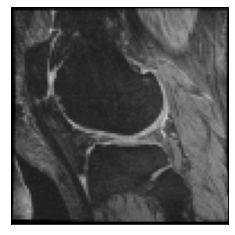

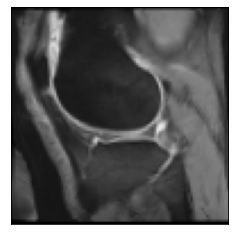

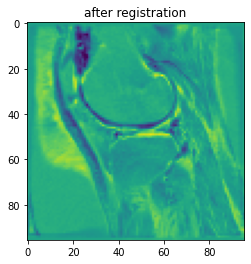

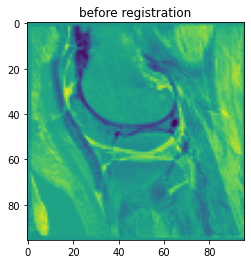

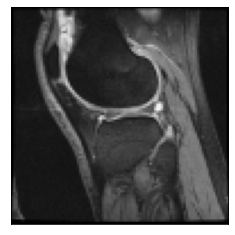

In [159]:
if not("N" in locals()):
    N = 0
N += 1
N %= 8
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()
plt.rcParams["figure.figsize"] = (4, 4)
def imshow(x):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
slice_ = 10
imshow(fixed_image[N, 0, slice_])
plt.show()
imshow(net.warped_image_A[N, 0, slice_])
plt.show()

plt.imshow(net.warped_image_B[N, 0, slice_].cpu().detach() - moving_image[N, 0, slice_].cpu().detach())
plt.title("after registration")
plt.show()
plt.imshow((fixed_image - moving_image)[N, 0, slice_].cpu().detach())
plt.title("before registration")
plt.show()

imshow(moving_image[N, 0, slice_].cpu().detach())
plt.show()

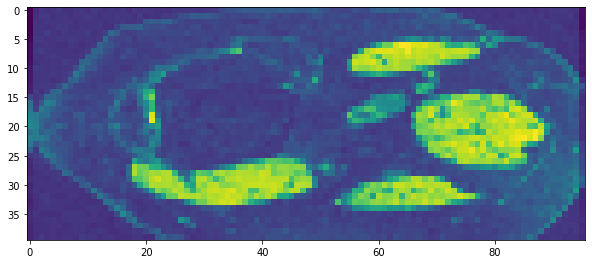

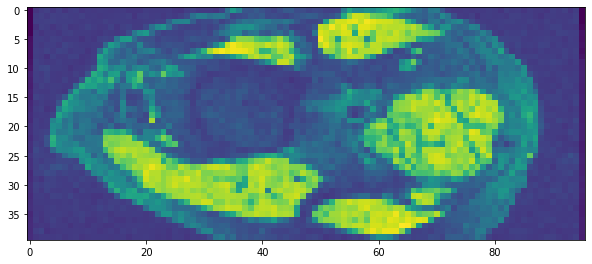

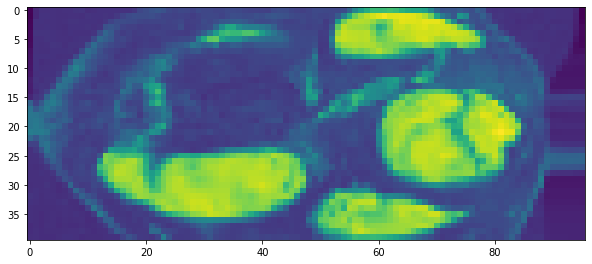

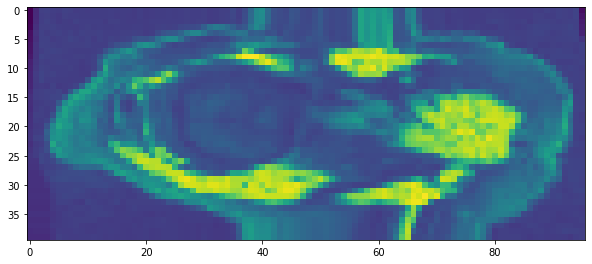

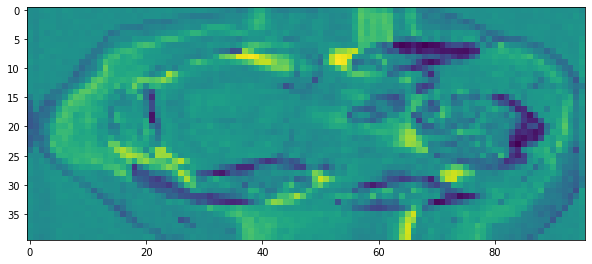

In [126]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach() - moving_image[0, 0, :, 10].cpu())

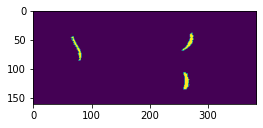

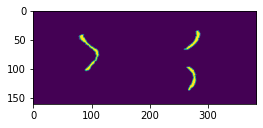

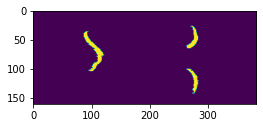

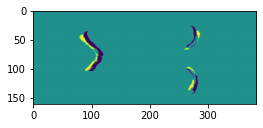

In [137]:
N +=1
N %= 8
S = 40
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()

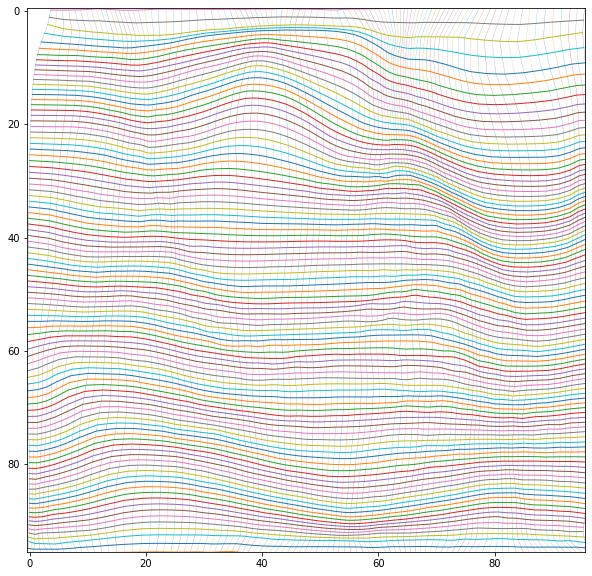

In [150]:
import visualize
N = (N + 1)% 8
plt.rcParams["figure.figsize"] = 10, 10
visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 10])

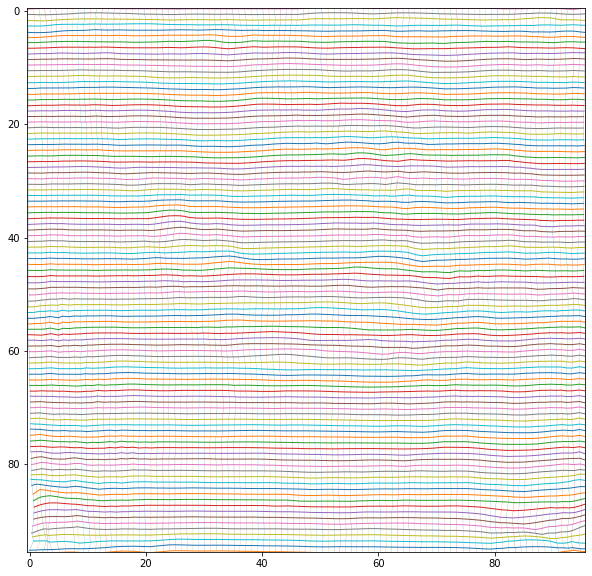

In [117]:
#N = (N + 1) % 8
visualize.show_as_grid(net.phi_BA(net.phi_AB(net.identityMap))[N, [1, 2], 30])

In [128]:
type(net.regisNet.netPhi)

ModuleAttributeError: 'InverseConsistentNet' object has no attribute 'regisNet'

In [129]:
net.lmbda

100

In [23]:
trained_weights.keys()

odict_keys(['identityMap', 'regis_net.identityMap', 'regis_net.net.identityMap', 'regis_net.net.net.identityMap', 'regis_net.net.net.dense1.weight', 'regis_net.net.net.dense1.bias', 'regis_net.net.net.dense2.weight', 'regis_net.net.net.dense2.bias', 'regis_net.net.net.dense3.weight', 'regis_net.net.net.dense3.bias', 'regis_net.net.net.dense4.weight', 'regis_net.net.net.dense4.bias'])

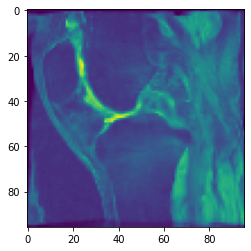

In [162]:
plt.imshow(net.warped_image_B[0, 0, 20].cpu().detach())

In [112]:
def flips2(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True) / np.product(net.spacing)
    return dV.detach().cpu()

dV = flips2(net.phi_AB_vectorfield)

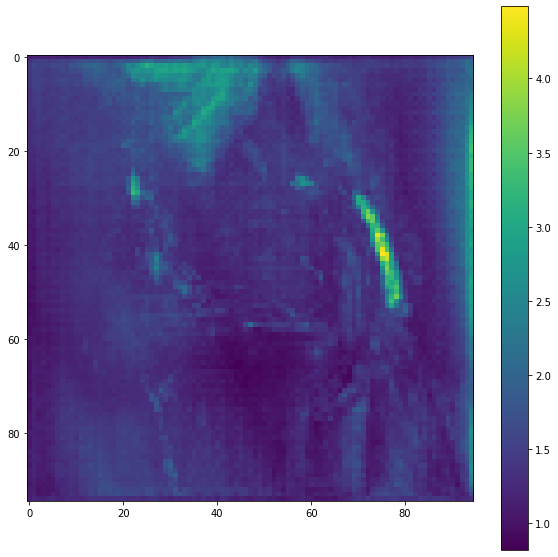

In [122]:
plt.imshow(torch.max(dV[2, 0], axis=0).values)
plt.colorbar()

In [95]:
torch.min(dV[0, 0], axis=2).values

tensor([[9.0962e-07, 1.3922e-06, 1.9076e-06,  ..., 2.0819e-06, 1.6802e-06,
         1.6636e-06],
        [9.6025e-07, 1.2300e-06, 1.3677e-06,  ..., 2.0941e-06, 1.6396e-06,
         1.8732e-06],
        [1.0567e-06, 1.1886e-06, 1.3409e-06,  ..., 2.0042e-06, 1.5364e-06,
         1.7836e-06],
        ...,
        [1.1789e-06, 8.0111e-07, 9.2926e-07,  ..., 1.9860e-06, 1.7852e-06,
         1.5311e-06],
        [1.2862e-06, 1.0192e-06, 1.1178e-06,  ..., 1.9306e-06, 1.7918e-06,
         1.6268e-06],
        [1.6100e-06, 1.3876e-06, 1.3956e-06,  ..., 2.1676e-06, 2.2221e-06,
         2.0933e-06]])

In [151]:
len(net.input_shape) - 2 == 3

True

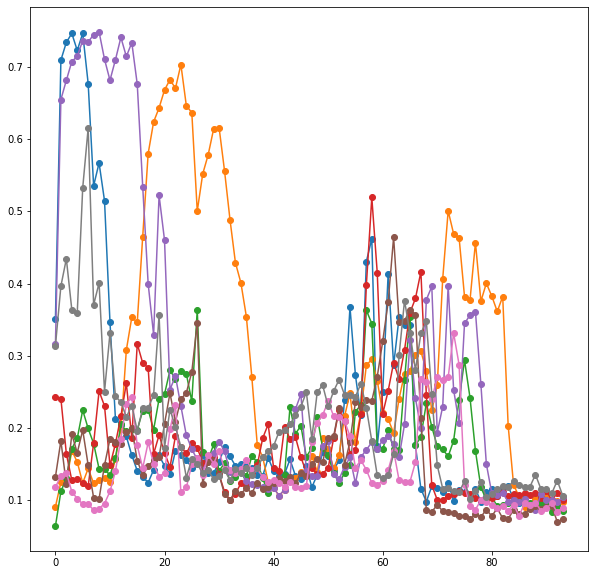

In [171]:
plt.plot(moving_image[:, 0, 20, 1:-1, 20].detach().cpu().transpose(0, 1), marker='o')
plt.show()

In [60]:
len(r_ds)

301

In [61]:
train_data = torch.load("/playpen/tgreer/knees_big_train_set")

In [62]:
len(train_data)

2532

In [51]:
net.parameters()

AttributeError: 'generator' object has no attribute 'first'

In [81]:
transform_components = trained_weights['regis_net.net.net.dense4.weight']

In [25]:
transform_components.shape

torch.Size([138240, 512])

In [49]:
j = 0

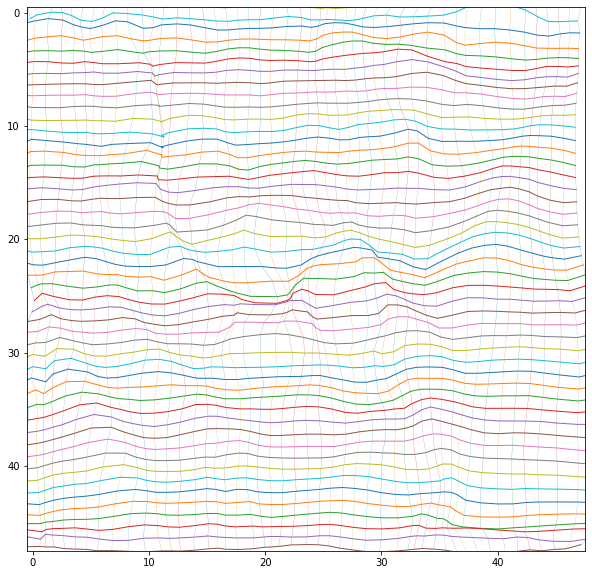

In [310]:
j += 1
component1 = transform_components[:, j].reshape((3, 20, 48, 48))
visualize.show_as_grid((10 * component1[None, :]+ net.regis_net.net.identityMap[:1])[0, [1, 2], 10] )

In [47]:
image_components = trained_weights['regis_net.net.net.dense1.weight'].cpu()

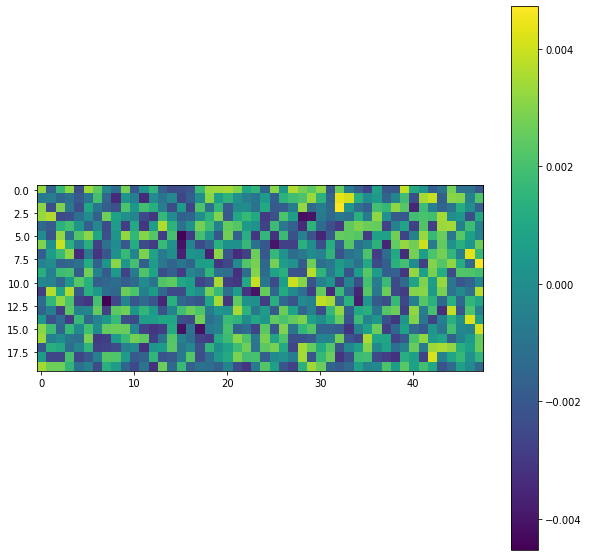

In [51]:
j += 1
component1 = image_components[j].reshape((2, 20, 48, 48))
plt.imshow(component1[1, :, 30])
plt.colorbar()

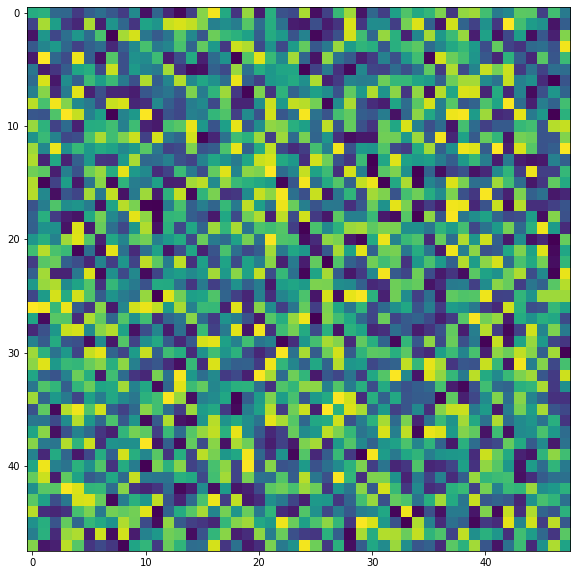